https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/

In [1]:
import numpy as np
import os
import pandas as pd
import re

In [2]:
data_dir = r'Data/'

In [3]:
file = np.loadtxt(fname=data_dir+'nertrnweather.txt',encoding='utf-8',dtype=str)
file

array([['अरे', 'O'],
       ['सारथी', 'O'],
       ['जम्मू', 'U-location'],
       ...,
       ['क्या', 'O'],
       ['है', 'O'],
       ['?', 'O']], dtype='<U14')

In [4]:
df = pd.DataFrame(columns=['Sentence #','Word','Tag'])

In [5]:
i=1
data = list()
with open(data_dir+'nertrnweather.txt',encoding='utf-8') as f:
    for line in f.readlines():
        if line=='\n':
            i+=1
        else:
            data=line.split(" ")
            df=df.append({"Sentence #":f"Sentence {i}","Word":data[0],"Tag":re.sub("\n","",data[1])},ignore_index=True)
df

,Sentence #,Word,Tag
0,Sentence 1,अरे,O
1,Sentence 1,सारथी,O
2,Sentence 1,जम्मू,U-location
3,Sentence 1,कैसा,O
4,Sentence 1,मौसम,O
...,...,...,...
1403,Sentence 203,की,O
1404,Sentence 203,स्थिति,O
1405,Sentence 203,क्या,O
1406,Sentence 203,है,O


In [6]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

282

In [7]:
tags = list(set(df["Tag"].values))
n_tags = len(tags); n_tags

10

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except Exception as e:
            print(e)
            return None

In [9]:
getter = SentenceGetter(df)

In [10]:
sent = getter.get_next()
print(sent)

[('अरे', 'O'), ('सारथी', 'O'), ('जम्मू', 'U-location'), ('कैसा', 'O'), ('मौसम', 'O'), ('है', 'O')]


In [11]:
sentences = getter.sentences

In [12]:
max_len = 16
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
tag2idx["U-location"]

3

In [14]:
X = [[w[0] for w in s] for s in sentences]

In [15]:
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

In [16]:
print(X[1])

['मुंबई', 'में', 'मौसम', 'की', 'स्थिति', 'क्या', 'है', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__', '__PAD__']


In [17]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [18]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [19]:
y[1]

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.14, random_state=2018)

In [22]:
batch_size = 29

In [23]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from keras import backend as K
# import keras.backend.tensorflow_backend as K

In [24]:
sess = tf.Session()
# K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess);

In [25]:
tf.disable_eager_execution()

In [26]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
# elmo_model = hub.load("https://tfhub.dev/google/elmo/2")
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [27]:
tokens_input = [["the", "cat", "is", "on", "the", "mat"]]
tokens_length = [6]
elmo_model(
    inputs={
        "tokens": tokens_input,
        "sequence_len": tokens_length
    },
    signature="tokens",
    as_dict=True)["elmo"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


<tf.Tensor 'module_apply_tokens/aggregation/mul_3:0' shape=(1, 6, 1024) dtype=float32>

In [28]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]
#     print(x,max_len)

#     return elmo_model.signatures["tokens"]({
#                             "tokens": tf.squeeze(tf.cast(x, tf.string)),
#                             "sequence_len": tf.constant(batch_size*[max_len])
#                       },
#                       as_dict=True)["elmo"]


In [29]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [30]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
print(embedding)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("lambda/module_apply_tokens/aggregation/mul_3:0", shape=(29, None, 1024), dtype=float32)


In [31]:
model = Model(input_text, out)

In [32]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [33]:
# X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
# y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
# X_tr = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
# y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
y_te = y_te.reshape(y_te.shape[0], y_te.shape[1], 1)

In [34]:
print(np.array(X_te).shape)
print(np.array(X_tr).shape)

(29, 16)
(174, 16)


In [35]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_te), y_te),
                    batch_size=batch_size, epochs=5, verbose=1)

Train on 174 samples, validate on 29 samples
Epoch 1/5
174/174 [==============================] - ETA: 0s - loss: 1.5768 - accuracy: 0.6832

D:\Sarika\NER\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


174/174 [==============================] - 36s 205ms/sample - loss: 1.5768 - accuracy: 0.6832 - val_loss: 0.6796 - val_accuracy: 0.6767
Epoch 2/5
174/174 [==============================] - 29s 168ms/sample - loss: 0.5876 - accuracy: 0.8276 - val_loss: 0.4351 - val_accuracy: 0.8750
Epoch 3/5
174/174 [==============================] - 27s 155ms/sample - loss: 0.3938 - accuracy: 0.8861 - val_loss: 0.3379 - val_accuracy: 0.9009
Epoch 4/5
174/174 [==============================] - 29s 167ms/sample - loss: 0.3230 - accuracy: 0.9023 - val_loss: 0.2796 - val_accuracy: 0.8793
Epoch 5/5
174/174 [==============================] - 29s 167ms/sample - loss: 0.2878 - accuracy: 0.8969 - val_loss: 0.2280 - val_accuracy: 0.9310


In [59]:
hist = pd.DataFrame(history.history)

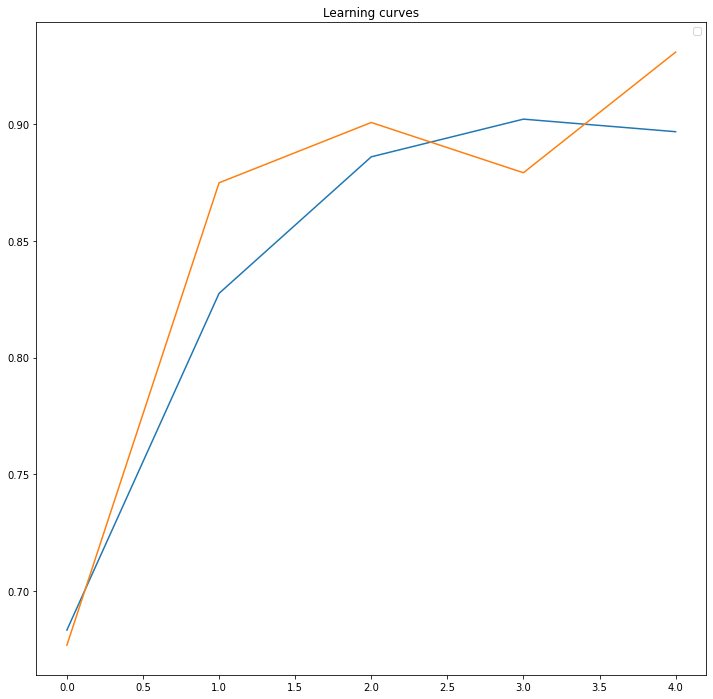

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curves")
plt.legend()
plt.show()

In [61]:
i = 0
p = model.predict(np.array(X_te[i:i+batch_size]))
p = np.argmax(p, axis=-1)
# print("{} {}: ({})".format("Word", "Pred", "True"))
# print("="*30)
# for w, true, pred in zip(X_te[i], y_te[i], p):
#     if w != "__PAD__":
#         print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

In [62]:
p

array([[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 1, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 9, 4, 5, 4, 3, 4, 9,

In [63]:
print("{} {}: ({})".format("Word", "Pred", "True"))
print("="*30)
c = 1
for X_te1, y_te1,p1 in zip(X_te,y_te.tolist(),p):
    print("Sentence ", c)
    c+=1
    for w, true, pred in zip(X_te1, y_te1, p1):
        if w != "__PAD__" and tags[pred] == tags[true[0]] and tags[true[0]]!='O':
            print("{}:{} ({})".format(w, tags[pred], tags[true[0]]))

Word Pred: (True)
Sentence  1
सिडनी:U-location (U-location)
Sentence  2
मनाली:U-location (U-location)
Sentence  3
आज:U-date (U-date)
गर्मी:U-weather_type (U-weather_type)
Sentence  4
बेंगलोरे:U-location (U-location)
Sentence  5
जौनपुर:U-location (U-location)
गर्म:U-weather_type (U-weather_type)
Sentence  6
Sentence  7
आज:U-date (U-date)
Sentence  8
गर्मी:U-weather_type (U-weather_type)
Sentence  9
बारिश:U-weather_type (U-weather_type)
Sentence  10
Sentence  11
आज:U-date (U-date)
Sentence  12
आज:U-date (U-date)
Sentence  13
इस:B-date (B-date)
गर्मी:U-weather_type (U-weather_type)
Sentence  14
बर्फ:U-weather_type (U-weather_type)
Sentence  15
बारिश:U-weather_type (U-weather_type)
Sentence  16
जम्मू:U-location (U-location)
Sentence  17
गर्मी:U-weather_type (U-weather_type)
Sentence  18
कल:U-date (U-date)
गर्म:U-weather_type (U-weather_type)
दिल्ली:U-location (U-location)
Sentence  19
कसोल:U-location (U-location)
Sentence  20
मुंबई:U-location (U-location)
गर्म:U-weather_type (U-weather_typ

## On nervalweather.txt

In [64]:
file = np.loadtxt(fname=data_dir+'nervalweather.txt',encoding='utf-8',dtype=str)
file

array([['आज', 'U-date'],
       ['मौसम', 'O'],
       ['कैसा', 'O'],
       ['है', 'O'],
       ['क्या', 'O'],
       ['हरिद्वार', 'U-location'],
       ['में', 'O'],
       ['बहुत', 'O'],
       ['ठंड', 'U-weather_type'],
       ['है', 'O'],
       ['अभी', 'U-date'],
       ['आज', 'U-date'],
       ['इतनी', 'O'],
       ['गर्मी', 'U-weather_type'],
       ['क्यों', 'O'],
       ['है', 'O'],
       ['क्या', 'O'],
       ['मुंबई', 'U-location'],
       ['में', 'O'],
       ['ठंडी', 'U-weather_type'],
       ['है', 'O'],
       ['क्या', 'O'],
       ['पाली', 'U-location'],
       ['में', 'O'],
       ['सर्दी', 'U-weather_type'],
       ['आ', 'O'],
       ['गयी', 'O'],
       ['क्या', 'O'],
       ['आज', 'U-date'],
       ['बारिश', 'U-weather_type'],
       ['हो', 'O'],
       ['सकती', 'O'],
       ['है', 'O'],
       ['किदर', 'O'],
       ['सबसे', 'O'],
       ['ज्यादा', 'O'],
       ['बारिश', 'U-weather_type'],
       ['होती', 'O'],
       ['है', 'O'],
       ['मुंबई', 'U-location'],
  

In [65]:
df = pd.DataFrame(columns=['Sentence #','Word','Tag'])

In [66]:
i=1
data = list()
with open(data_dir+'nervalweather.txt',encoding='utf-8') as f:
    for line in f.readlines():
        if line=='\n':
            i+=1
        else:
            data=line.split(" ")
            df=df.append({"Sentence #":f"Sentence {i}","Word":data[0],"Tag":re.sub("\n","",data[1])},ignore_index=True)
df

,Sentence #,Word,Tag
0,Sentence 1,आज,U-date
1,Sentence 1,मौसम,O
2,Sentence 1,कैसा,O
3,Sentence 1,है,O
4,Sentence 2,क्या,O
...,...,...,...
125,Sentence 21,रेणुकूट,U-location
126,Sentence 21,में,O
127,Sentence 21,मौसम,O
128,Sentence 21,कैसा,O


In [67]:
words = list(set(df["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

57

In [68]:
# tags = list(set(df["Tag"].values))
# n_tags = len(tags); n_tags


#use old tags, in netvalweather.txt, there are only 6 tags -> outofbounds error

In [69]:
getter = SentenceGetter(df)

In [70]:
sent = getter.get_next()
print(sent)

[('आज', 'U-date'), ('मौसम', 'O'), ('कैसा', 'O'), ('है', 'O')]


In [71]:
sentences = getter.sentences

In [72]:
max_len = 16
tag2idx = {t: i for i, t in enumerate(tags)}

In [73]:
X_test = [[w[0] for w in s] for s in sentences]

In [74]:
new_X = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X_test = new_X

In [75]:
y_test = [[tag2idx[w[1]] for w in s] for s in sentences]

In [76]:
from keras.preprocessing.sequence import pad_sequences
y_test = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [77]:
print(len(X_test))
X_test += X_test[0:8]
print(len(X_test))

#making size = batch_size

21
29


In [78]:
i = 0

p = model.predict(np.array(X_test))
p = np.argmax(p, axis=-1)

In [79]:
p

array([[9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [9, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       [4, 9, 5, 4, 4, 4, 4, 4,

In [80]:
print("{} {}: ({})".format("Word", "Pred", "True"))
print("="*30)
c = 1
for X_te1, y_te1,p1 in zip(X_test,y_test,p):
    print("Sentence ", c)
    c+=1
    for w, true, pred in zip(X_te1, y_te1, p1):
        if w != "__PAD__" and tags[pred] == tags[true] and tags[true]!='O':
            print("{}:{} ({})".format(w, tags[pred], tags[true]))

Word Pred: (True)
Sentence  1
Sentence  2
Sentence  3
Sentence  4
Sentence  5
Sentence  6
Sentence  7
Sentence  8
Sentence  9
बनारस:U-location (U-location)
Sentence  10
बनारस:U-location (U-location)
Sentence  11
Sentence  12
Sentence  13
पठानकोट:U-location (U-location)
Sentence  14
Sentence  15
Sentence  16
मुंबई:U-location (U-location)
Sentence  17
Sentence  18
Sentence  19
Sentence  20
Sentence  21
Sentence  22
Sentence  23
Sentence  24
मनाली:U-location (U-location)
Sentence  25
Sentence  26
Sentence  27
Sentence  28
Sentence  29


In [81]:
c = 1
acc = 0
total = 0
for X_te1, y_te1,p1 in zip(X_test,y_test,p):
#     print("Sentence ", c)
    c+=1
    for w, true, pred in zip(X_te1, y_te1, p1):
        if w != "__PAD__" and tags[pred] == tags[true] :
            acc+=1
        total +=1
print("Accuracy on nervalweather.txt = ", acc/total)

Accuracy on nervalweather.txt =  0.2025862068965517
